In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# Table of Contents
1. [Exploration](#Exploration)
2. [Preprocessing](#Preprocessing)
3. [Initial Models](#Initial-Models)
4. [Further Tuning](#Further-Tuning)
5. [Results](#Results)
6. [Conclusion](#Conclusion)

A Caesarean section a.k.a. the "C-section" is a surgical procedure made on the abdomen to the uterus to help deliver a baby. Often times, doctors recommend it when there complications to the birthing process. For example, the baby is in an unusal position, labor isn't proceeding normally, or if there are certain health concerns for the mother ([MayoClinic](https://www.mayoclinic.org/tests-procedures/c-section/about/pac-20393655)). However, mothers can elect to getting the procedure themselves - usually for their first born. Of course, the procedure also has its risk for both the mother and baby.

Knowing when to perform a c-section is vital to both the mother and the child. This sounds like a classification problem. The classification can be performed using supervised learning methods.

This project will then try to do just that - create a model that hopefully is able to correctly predict when to do a c-section and when not to. Multiple supervised learning models will be made and compared against each to determine the best model. 

The dataset was taken from the UC Irvine Machine Learning Repository. The dataset is going to be used to train a model that will hopefully predict correctly when and when not to perform a Caesarean section on a pregnant lady during birth ([Source](https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset)).

According to the description of the dataset provided on the repository the features in this data set is...

- <b>Age</b> is an integer.
- <b>Delivery number</b> is an integer from 1 to 4.
- <b>Delivery time</b> is an integer from 0 to 2 where 0=timely, 1=premature, and 2=latecomer.
- <b>Blood of Pressure</b> is an integer from 0 to 2 where 0=low, 1=normal, 2=high blood pressure.
- <b>Heart Problem</b> is an integer 0 or 1 where 0 means there was a heart problem present.
- <b>Caesarian</b> is an integer 0 or 1 where 0 means "No" caesarian section.

There are 80 samples total which is a decent size of samples. We may assume normality if the data shows signs of it because our sample is "large". Although it's always more helpful to have more data samples overall.

\
Source:

Ali, A., and Amin, M.H.(2018).<i>Caesarian Section Classification Dataset Data Set</i> [datafile]. University of California, Irvine. [Link](https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset)

# Exploration

First we are going to load the .arff file that contains the data set and reformat the feature types.

In [2]:
# loading the .arff file
data = arff.loadarff('caesarian.csv.arff')

# making a dataframe for the dataset
df = pd.DataFrame(data[0])
df.head()

,Age,Delivery number,Delivery time,Blood of Pressure,Heart Problem,Caesarian
0,b'22',b'1',b'0',b'2',b'0',b'0'
1,b'26',b'2',b'0',b'1',b'0',b'1'
2,b'26',b'2',b'1',b'1',b'0',b'0'
3,b'28',b'1',b'0',b'2',b'0',b'0'
4,b'22',b'2',b'0',b'1',b'0',b'1'


The data set doesn't look very neat with the 'b' term in front of every sample. Let's see if we can fix that.

In [3]:
catCols = [col for col in df.columns if df[col].dtype=="O"]
catCols[:5]
df[catCols]=df[catCols].apply(lambda x: x.str.decode('utf8'))

In [4]:
df.head()

,Age,Delivery number,Delivery time,Blood of Pressure,Heart Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0
3,28,1,0,2,0,0
4,22,2,0,1,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                80 non-null     object
 1   Delivery number    80 non-null     object
 2   Delivery time      80 non-null     object
 3   Blood of Pressure  80 non-null     object
 4   Heart Problem      80 non-null     object
 5   Caesarian          80 non-null     object
dtypes: object(6)
memory usage: 3.9+ KB


The data type of each feature and label are strings which isn't very helpful in creating a model. We would have to try to make it into an integer or float data type.

In [6]:
# changing the data type of the data set into integers from objects/strings
df = df.apply(pd.to_numeric)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                80 non-null     int64
 1   Delivery number    80 non-null     int64
 2   Delivery time      80 non-null     int64
 3   Blood of Pressure  80 non-null     int64
 4   Heart Problem      80 non-null     int64
 5   Caesarian          80 non-null     int64
dtypes: int64(6)
memory usage: 3.9 KB


I am also going to be turning the values in the heart problems feature column around to 0=No heart problem, 1=has heart problem instead of the opposite because it's going to confuse me.

In [8]:
# switching 0 for 1s and 1s for 0s
df['Heart Problem']=df['Heart Problem'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
# changing title of column 
df = df.rename({'Blood of Pressure': 'Blood Pressure'}, axis=1)

In [10]:
df.head(3)

,Age,Delivery number,Delivery time,Blood Pressure,Heart Problem,Caesarian
0,22,1,0,2,1,0
1,26,2,0,1,1,1
2,26,2,1,1,1,0


Looks like there is no null values within the dataset.

At a quick glance at this data, it's primarily focusing on the status of the mother in determining whether c-sections were done. This might give a limited prediction model because the status of the baby is also important in determining when to perform the procedure. It also does not say whether it was recommended by the doctor or whether the mother initiated the talks and wanted to do it. Because this is missing the training data for the model can be a little confusing. This may lower the overall accuracy of the model because the model may learn a pattern and predict not to perform it, however samples in the test set may have gone ahead with the procedure under those same conditions. 

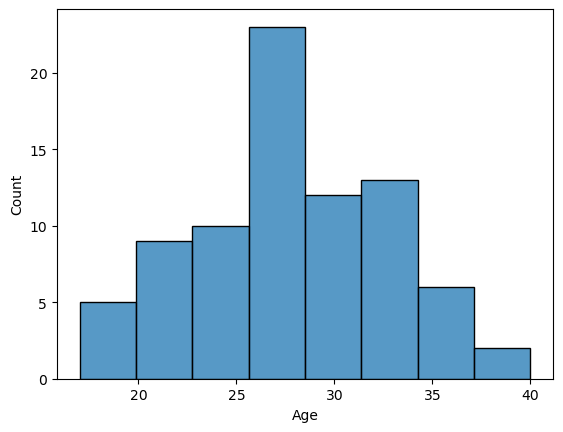

In [11]:
sns.histplot(data=df, x='Age')
plt.show()

The distribution of age is sort of normal with the most occurence around ages 27-28.

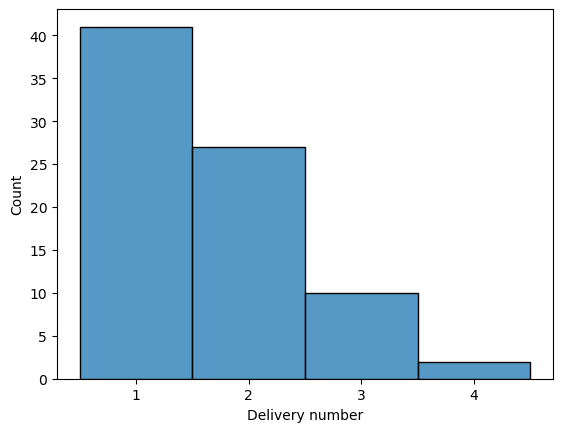

In [12]:
sns.histplot(x = df['Delivery number'].astype(str))
plt.show()

The vast majority of deliveries in this data set were 1st or 2nd in line. Although there is very few people that 4th in line, it's important to keep this data especially when it's a relatively small data set. 

It should be fine that this isn't normal, but it would have been helpful if it was a little more uniform because there is very few data for delivery number 4 and 3 in comparison. This is going to put a little more weight on later deliveries.

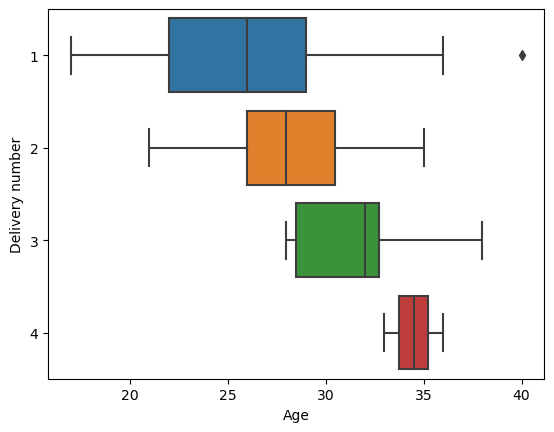

In [13]:
sns.boxplot(x = df.Age, y = df['Delivery number'].astype(str))
plt.show()

According to the boxplot, the general trend is that the older you are, the later in line you will be for delivery. There is an outlier far right of the boxplot of delivery numer 1. Let's see what this is.

In [14]:
df[df.Age == 40]

,Age,Delivery number,Delivery time,Blood Pressure,Heart Problem,Caesarian
31,40,1,0,1,0,1


There is only one point. Looking at the sample, it is a 40 year old lady that was relatively normal: no heart problem and had normal blood presure. She was first in line for delivery and had a c-section performed. The reason is probably because it was a premature baby (delivery time=0). There is probably also some context to this besides what's presented.

Because it's an outlier and only 1 point among the many samples under the "delivery number" feature, I think it would be fine to remove it.

In [15]:
# dropping the outlier found above.
df = df.drop(df[df.Age == 40].index, axis=0)

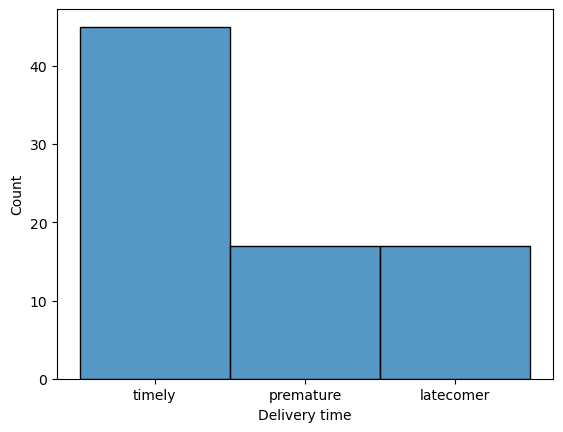

In [16]:
sns.histplot(x = df['Delivery time'].astype(str))
plt.xticks([0, 1, 2], ['timely', 'premature', 'latecomer'])
plt.show()

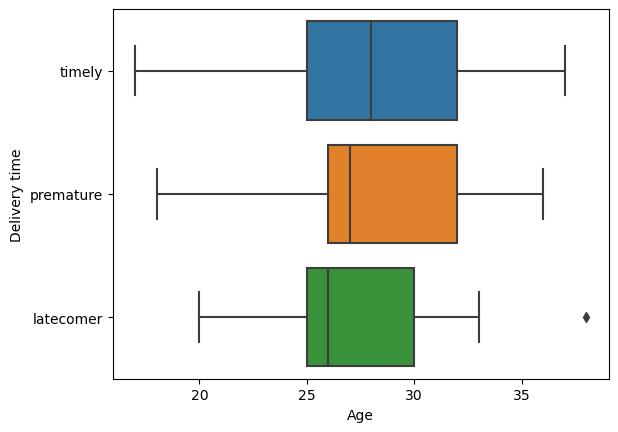

In [17]:
sns.boxplot(x = df.Age, y = df['Delivery time'].astype(str))
plt.yticks([0,1,2], ['timely', 'premature', 'latecomer'])
plt.show()

Most often the delivery is timely according to the bar chart. The median age for each delivery time is roughly the same - For a timely delivery, the median age is 28 years old, 27 for premature and 26 for latecomers. 

This boxplot also shows an outlier in the latecomer column. Let's examine it further.

In [18]:
df.loc[(df['Delivery time'] == 2) & (df.Age > 35)]

,Age,Delivery number,Delivery time,Blood Pressure,Heart Problem,Caesarian
74,38,3,2,2,0,1


The outlier is a 38 year old lady that delivered 3rd in line, and was a latecomer. She had high blood pressure, did not have a heart problem and ended up performing the c-section. 

Because this is only 1 sample point as well and it falls under delivery number 3 where there's a relatively decent set size, I am going to remove it.

In [19]:
# dropping the outlier
df = df.drop(df.loc[(df['Delivery time'] == 2) & (df.Age > 35)].index, axis=0)

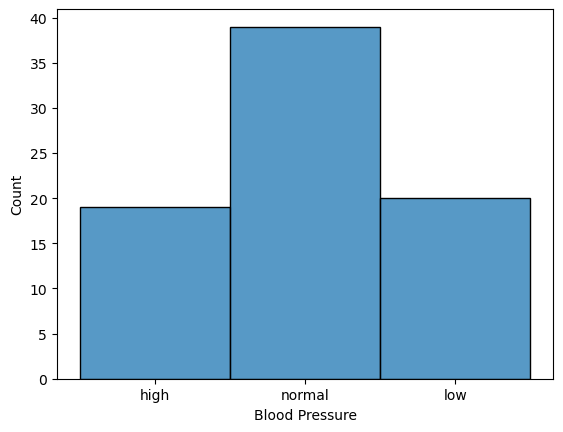

In [20]:
sns.histplot(x = df['Blood Pressure'].astype(str))
plt.xticks([2, 1, 0], ['low', 'normal', 'high'])
plt.xlabel('Blood Pressure')
plt.show()

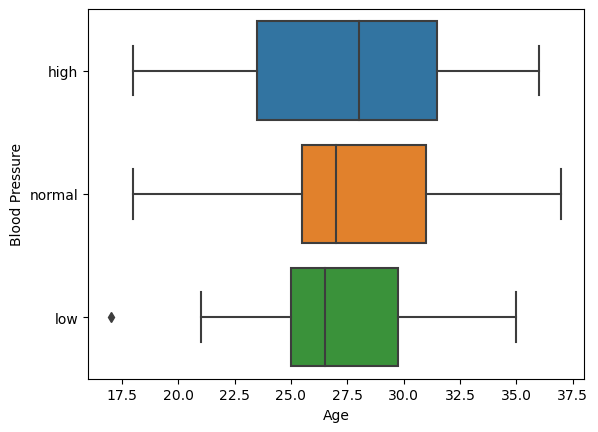

In [21]:
sns.boxplot(x = df.Age, y = df['Blood Pressure'].astype(str))
plt.yticks([2, 1, 0], ['low', 'normal', 'high'])
plt.ylabel('Blood Pressure')
plt.show()

The bar plot shows a relatively normal distribution with the most occurences at normal pressure. The boxplot shows that older mothers tend to have higher blood pressure. The median age being around 28 for high blood pressure.

There is an outlier on the low blood pressure column on the far left. The outlier is from a teen birth looking at the age.

In [22]:
df.loc[(df['Blood Pressure'] == 0) & (df.Age < 20)]

,Age,Delivery number,Delivery time,Blood Pressure,Heart Problem,Caesarian
70,17,1,0,0,1,1


A teenage mother who has low blood pressure and a heart problem. I am going to remove this outlier sample as well because the sample seems a little too far away from the rest. As seen on the box plot, the lowest on the other blood pressure categories was 18 years old.

In [23]:
df = df.drop(df.loc[(df['Blood Pressure'] == 0) & (df.Age < 20)].index, axis=0)

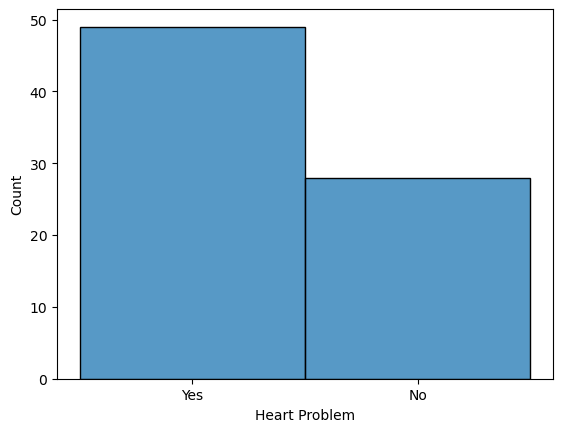

In [24]:
sns.histplot(x = df['Heart Problem'].astype(str))
plt.xticks([0, 1], ['Yes', 'No'])
plt.show()

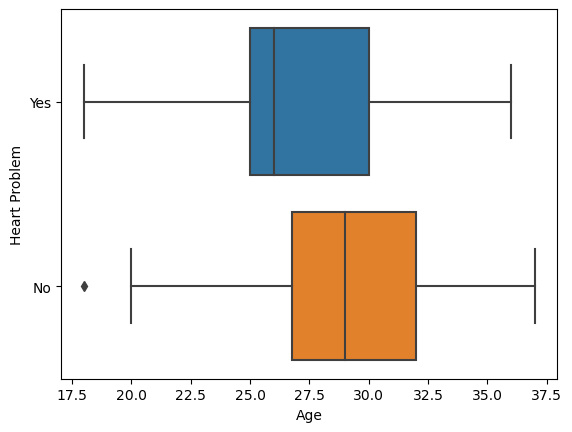

In [25]:
sns.boxplot(x = df.Age, y = df['Heart Problem'].astype(str))
plt.yticks([0, 1], ['Yes', 'No'])
plt.show()

More often than not, older mothers preparing for delivery tend to have some sort of heart problem with a median age of 28-29 years. Mothers who don't have heart problems have a median age of around 26 years. The data is a litte uneven which may make it hard to generalize in our model.

Another outlier is seen here under the condition of not having a heart problem. The outlier is very young compared to the rest of its group. Because of this reason, I am going to remove it.

In [26]:
df = df.drop(df.loc[(df['Heart Problem'] == 0) & (df.Age < 20)].index, axis=0)

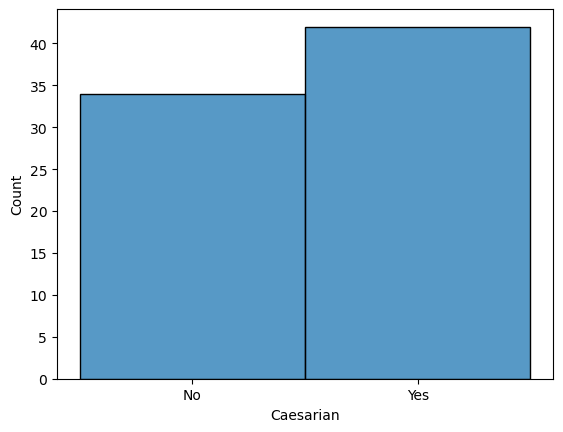

In [27]:
sns.histplot(x = df['Caesarian'].astype(str))
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

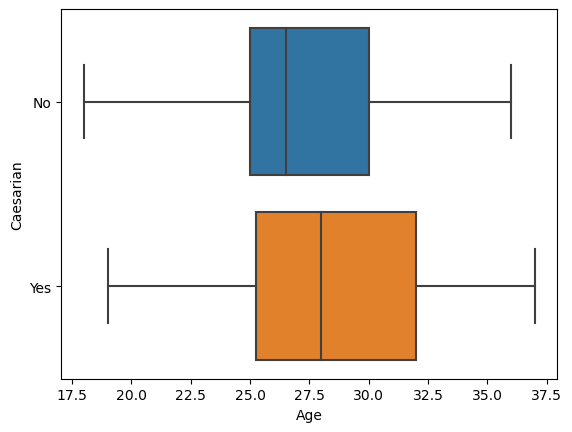

In [28]:
sns.boxplot(x = df.Age, y = df['Caesarian'].astype(str))
plt.yticks([0, 1], ['No', 'Yes'])
plt.show()

The median age of mothers needing a caesarian is around 28 years compared to not getting one with a median of 27 years of age. Mothers who don't need a caesarian have a more narrower distribution, where most of the mothers from ages 25 to 30 don't need one. In contrast, most mothers who go through a caesarian are ages 25 to 32.

Older women tend to go through with the caesarian procedure. Looking at the bar chart, the distribution between the two options seem relatively even, with "No" having around 34 samples and "Yes" having around 42. The percent distribution is 45/55 for no/yes respectively.

<AxesSubplot:>

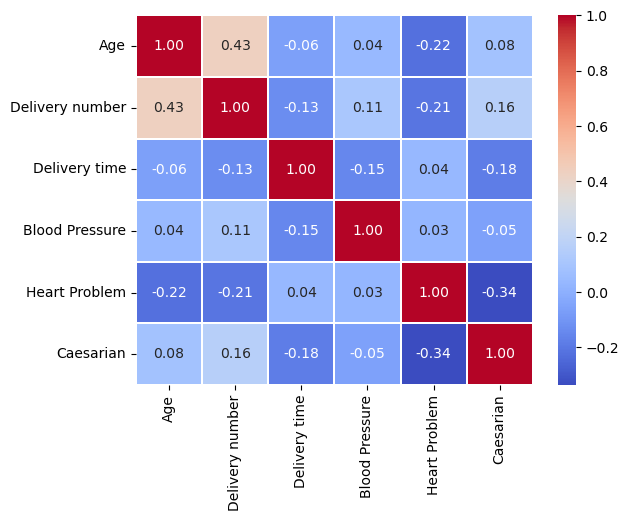

In [29]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=0.1, cmap='coolwarm')

Looking at the correlation between going through a caesarian and the other features, the strongest positive correlation is with the presence of a heart problem. There is also a negative correlation between having a caesarian and the delivery time - the earlier the delivery, the less likely a caesarian would be needed. Strangely enough, the delivery number seems to positively correlate with the age of the mother which we had a glimpse of in a prior boxplot.

# Preprocessing

Because some features don't scale well with each other such as age and delivery number, I am going to scale the features between 0 and 1 to use as training data.

In [30]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.to_numpy())
df = pd.DataFrame(df_scaled, columns = [
    'Age', 'Delivery_Number', 'Delivery_time', 'Blood_pressure', 'Heart_problem', 'Caesarian'])
df.head()

,Age,Delivery_Number,Delivery_time,Blood_pressure,Heart_problem,Caesarian
0,0.210526,0.000000,0.0,1.0,1.0,0.0
1,0.421053,0.333333,0.0,0.5,1.0,1.0
2,0.421053,0.333333,0.5,0.5,1.0,0.0
3,0.526316,0.000000,0.0,1.0,1.0,0.0
4,0.210526,0.333333,0.0,0.5,1.0,1.0


In [31]:
x = np.array(df.drop('Caesarian', axis=1))
y = np.array(df.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

# Initial Models

## Logistic Regression

In [32]:
LogReg = LogisticRegression()

In [33]:
LogReg.fit(x_train, y_train)
y_pred = LogReg.predict(x_test)



              precision    recall  f1-score   support

         0.0       0.57      0.89      0.70         9
         1.0       0.89      0.57      0.70        14

    accuracy                           0.70        23
   macro avg       0.73      0.73      0.70        23
weighted avg       0.76      0.70      0.70        23



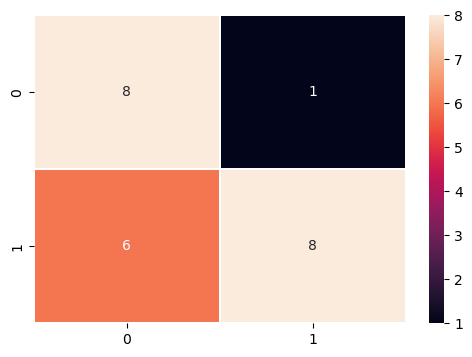

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, y_pred))

Using the default settings for the logistic regression model, it had a 70% accuracy rate. It looks to do very well identifying true negatives. It has a hard time predicting when to perform the c-section, predicting to do it correctly 8 out of 14 times.

Text(0.7, 0.2, 'AUC=0.794')

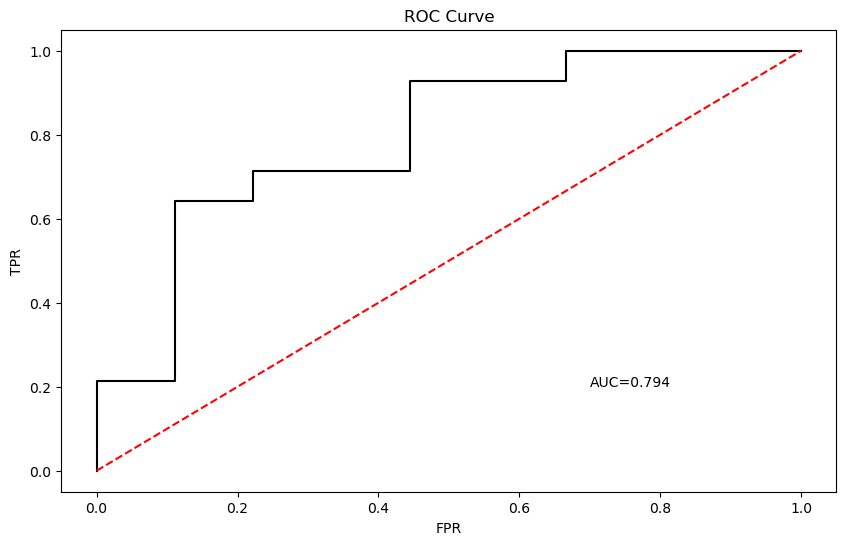

In [35]:
ypp = LogReg.predict_proba(x_test)
fpr, tpr, th = roc_curve(y_test, ypp[:,1])
auc = roc_auc_score(y_test, ypp[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC=' +'{:.3f}'.format(auc))

The ROC curve shows a decent result. As the false positive rate(FPR) increases, the chances of the result bveing a true positive (TPR) is higher in comparison. This is a good sign. 

## Decision Tree

In [36]:
dt = DecisionTreeClassifier(random_state=32).fit(x_train, y_train)

In [37]:
yp_dt = dt.predict(x_test)

              precision    recall  f1-score   support

         0.0       0.29      0.22      0.25         9
         1.0       0.56      0.64      0.60        14

    accuracy                           0.48        23
   macro avg       0.42      0.43      0.43        23
weighted avg       0.45      0.48      0.46        23



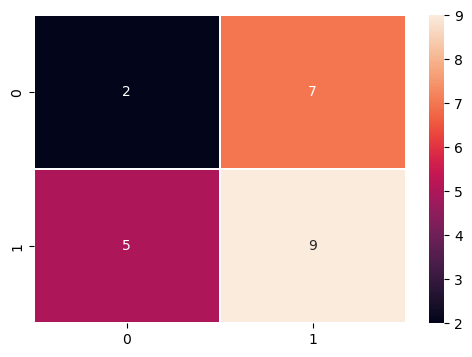

In [38]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, yp_dt), annot = True, linewidths=0.1)

print(classification_report(y_test, yp_dt))

The decision tree doesn't do as well. Overall accuracy is 48% which is as good as a coin flip. Not very promising.

## Random Forest

In [39]:
rf = RandomForestClassifier().fit(x_train, y_train)
yp_rf = rf.predict(x_test)

              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         9
         1.0       0.57      0.57      0.57        14

    accuracy                           0.48        23
   macro avg       0.45      0.45      0.45        23
weighted avg       0.48      0.48      0.48        23



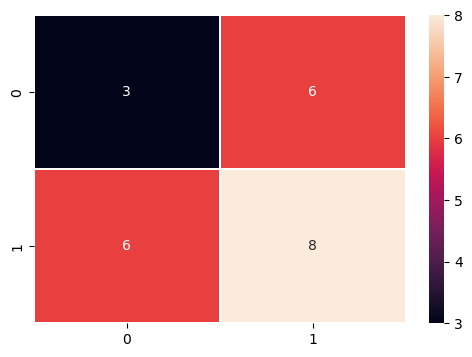

In [40]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, yp_rf), annot = True, linewidths=0.1)

print(classification_report(y_test, yp_rf))

A random forest does even worse than the decision tree model at 43% accuracy.

## Support Vector Machine (SVM)

In [41]:
svm = SVC().fit(x_train, y_train)
yp_svm = svm.predict(x_test)

              precision    recall  f1-score   support

         0.0       0.55      0.67      0.60         9
         1.0       0.75      0.64      0.69        14

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.67      0.65      0.66        23



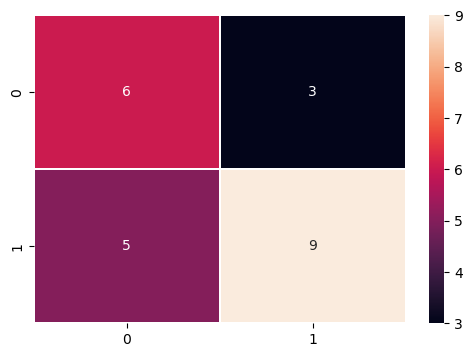

In [42]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, yp_svm), annot = True, linewidths=0.1)

print(classification_report(y_test, yp_svm))

SVM shows another decent model at accuracy of 65%. The confusion matrix shows relatively good results, recommending a c-section when supposed to.

## K-Nearest Neighbors (KNN)

C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

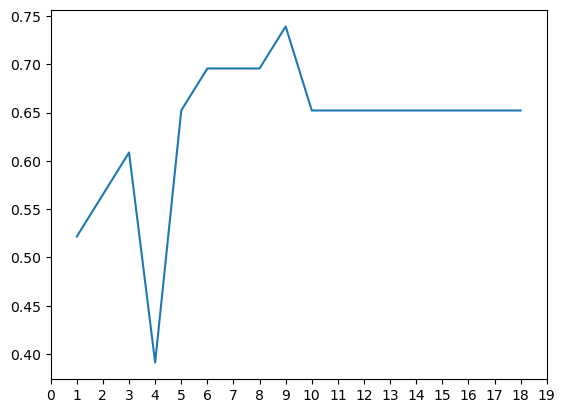

In [43]:
# looking for optimal k-value for KNN model.
knn_scores = []
for i in range(1, 19):
    knn = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
    score = knn.score(x_test, y_test)
    knn_scores.append(score)

plt.plot(range(1, 19), knn_scores)
plt.xticks(np.arange(0, 20, 1.0))
plt.show()

k = 9 had the highest accuracy earliest so we are going to use that to create the model.

In [44]:
knn = KNeighborsClassifier(n_neighbors=9).fit(x_train, y_train)
yp_knn = knn.predict(x_test)

C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)




              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73         9
         1.0       0.90      0.64      0.75        14

    accuracy                           0.74        23
   macro avg       0.76      0.77      0.74        23
weighted avg       0.79      0.74      0.74        23



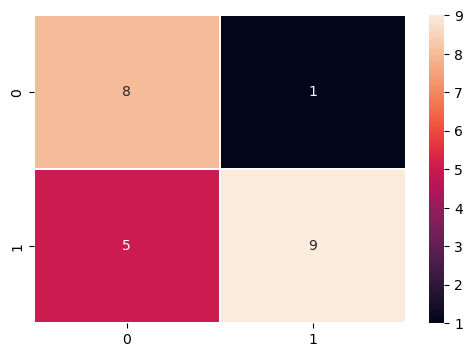

In [45]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, yp_knn), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, yp_knn))

The KNN model shows the best results so far at 74% accuracy. It does very well predicting true negatives.

## AdaBoost

In [46]:
ada = AdaBoostClassifier(random_state=32).fit(x_train, y_train)
yp_ada = ada.predict(x_test)

              precision    recall  f1-score   support

         0.0       0.50      0.44      0.47         9
         1.0       0.67      0.71      0.69        14

    accuracy                           0.61        23
   macro avg       0.58      0.58      0.58        23
weighted avg       0.60      0.61      0.60        23



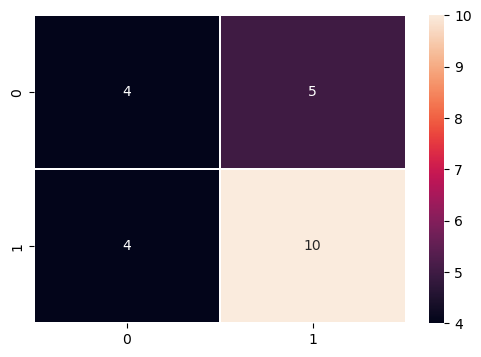

In [47]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, yp_ada), annot = True, linewidths=0.1)

print(classification_report(y_test, yp_ada))

The adaboost model has a decent accuracy among the selection at 61%. In comparison to the other models, it had the lowest false negative rate at 4/14 = 0.29.

The models were trained using training data with a split of 7/3. The models were then using the testing data to predict an outcome.

In summary, in regards to accuracy...

- Logistic Regression: 0.70
- Decision Tree: 0.48
- Random Forest: 0.43
- SVM: 0.65
- KNN (k=9): 0.74
- Adaboost: 0.61

Accuracy is good and all but in the context of this data set, it's important to reduce false negatives, recommending not getting a caesarean when they need one, as much as possible. Some circumstances may require it such as the position of the baby or the baby can't fit through the vaginal canal (Source: [PennMedicine](https://www.pennmedicine.org/updates/blogs/womens-health/2017/february/should-you-have-a-c-section-birth)). Thus not getting it when needed may bring danger to both the mother and the baby.

Of course, this data set doesn't have information position or size of the baby. But it's important to keep that in mind when making further models. 

The false negative rates (FNR) is calculated by $\frac{False Negative}{False Negative\ + \  True Positive}$

The FNR...
- Logistic Regression: 0.43
- Decision Tree: 0.36
- Random Forest: 0.43
- SVM: 0.36
- KNN: 0.36
- Adaboost: 0.29

Taking both into factors into consideration, the random forest model seems to do the worst among the models - lowest accuracy and highest FNR. The decision tree had doesn't seem so good as well with accuracy around 50%. The other 4 models: Logistic Regression, SVM, KNN, and Adaboost seem decent enough to see if further improvements can be made.

# Further Tuning

## Logistic Regression Tuning

In [48]:
logit_model = sm.Logit(y_train, x_train).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.645973
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   53
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Dec 2022   Pseudo R-squ.:                 0.06590
Time:                        16:02:16   Log-Likelihood:                -34.237
converged:                       True   LL-Null:                       -36.652
Covariance Type:            nonrobust   LLR p-value:                    0.3051
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032      1.051      0.003      0.998      -2.058       2.064
x2             1.2290      1.

Looking at the p-values for each feature, the first variable (Age) seems unsignificant in our model because the p-value is so high at 0.998. We are going to do feature removal starting from the highest p-value and see whether it's going to improve the model.

In [49]:
# dropping the first variable, 'Age' from the dataframe.
df1 = df.drop('Age', axis=1)
x = np.array(df1.drop('Caesarian', axis=1))
y = np.array(df1.Caesarian)

# recreating the train and test sets without the 'Age' variable. 
# random_state is used to control the split randomness.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

In [50]:
logit_model1 = sm.Logit(y_train, x_train).fit()
print(logit_model1.pvalues)

Optimization terminated successfully.
         Current function value: 0.645973
         Iterations 5
[0.22503139 0.77903843 0.46274448 0.08538782]


Remember all we have left now are the variables [delivery number, delivery time, blood pressure, heart problem]. After the removal of the 'Age' variable, the p-values for the remaining have changed. The lowest and most significant variable is the heart problem variable which we saw a glimpse in the correlation heatmap. 

Let's see how it does.



              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73         9
         1.0       0.90      0.64      0.75        14

    accuracy                           0.74        23
   macro avg       0.76      0.77      0.74        23
weighted avg       0.79      0.74      0.74        23



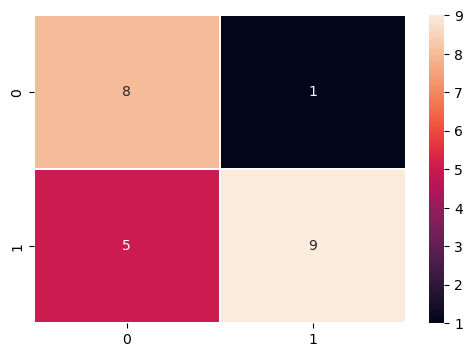

In [51]:
y_pred = logit_model1.predict(x_test)
y_pred = np.round(y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, y_pred))

It does slightly better gaining accuracy compared to its original form. Initially, it predicted 6 false negatives (the bottom left box) and now it predicted 5. We shall continue the feature removal and see if it changes anything else.

The next feature to remove is feature '2' from the recent removal. Feature '2' is feature '3' from the original data set and this would be the 'delivery time' variable.

In [52]:
df1 = df1.drop('Delivery_time', axis=1)
x = np.array(df1.drop('Caesarian', axis=1))
y = np.array(df1.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

logit_model2 = sm.Logit(y_train, x_train).fit()
print(logit_model2.pvalues)

Optimization terminated successfully.
         Current function value: 0.646718
         Iterations 5
[0.20622702 0.4563945  0.0829034 ]




              precision    recall  f1-score   support

         0.0       0.57      0.89      0.70         9
         1.0       0.89      0.57      0.70        14

    accuracy                           0.70        23
   macro avg       0.73      0.73      0.70        23
weighted avg       0.76      0.70      0.70        23



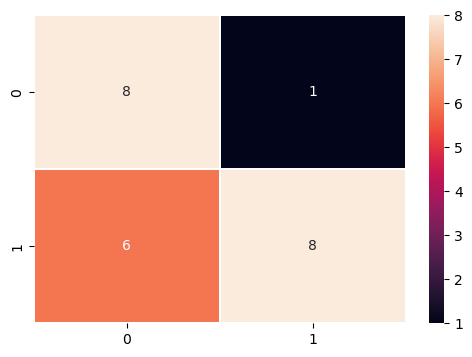

In [53]:
y_pred = np.round(logit_model2.predict(x_test))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, y_pred))

It did the same as the initial model did. Worse if compared to the previous model tuning. 

Let's keep going to see where it goes. The next one is feature '2' on the recent removal which is feature '4' on the original set which is 'blood pressure'.

In [54]:
df1 = df1.drop('Blood_pressure', axis=1)
x = np.array(df1.drop('Caesarian', axis=1))
y = np.array(df1.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

logit_model3 = sm.Logit(y_train, x_train).fit()
print(logit_model3.pvalues)

Optimization terminated successfully.
         Current function value: 0.652047
         Iterations 5
[0.08613467 0.10668891]




              precision    recall  f1-score   support

         0.0       0.50      0.89      0.64         9
         1.0       0.86      0.43      0.57        14

    accuracy                           0.61        23
   macro avg       0.68      0.66      0.61        23
weighted avg       0.72      0.61      0.60        23



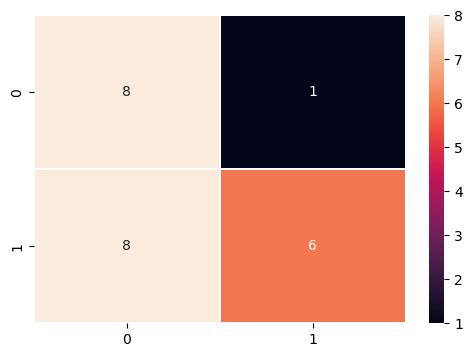

In [55]:
y_pred = np.round(logit_model3.predict(x_test))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, y_pred))

it does even worse lowering the accuracy down to 61%.

So far from the trend, we are seeing that removing more features beyond the first one doesn't improve the model any further, but instead decreases it. 

Let's see if anything changes if we try to tune the parameters in the model that gave the best results so far.

In [56]:
df1 = df.drop(['Age'], axis=1)
x = np.array(df1.drop('Caesarian', axis=1))
y = np.array(df1.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

log_params = {
    'penalty': ['l2', 'l1'],
    'fit_intercept': [True, False],
    'C': [0.01, 0.1, 0.3, 0.2, 0.5, 1, 2, 5, 10, 20], 
    'max_iter': [50, 75, 100, 500, 1000, 5000],
    'class_weight': ['balanced', 'none']
}
grid = GridSearchCV(estimator=LogisticRegression(solver='saga'),
                   param_grid=log_params,
                   cv=4).fit(x_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Params: {grid.best_params_}')

Best Score: 0.679945054945055
Params: {'C': 5, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2'}




              precision    recall  f1-score   support

         0.0       0.53      0.89      0.67         9
         1.0       0.88      0.50      0.64        14

    accuracy                           0.65        23
   macro avg       0.70      0.69      0.65        23
weighted avg       0.74      0.65      0.65        23



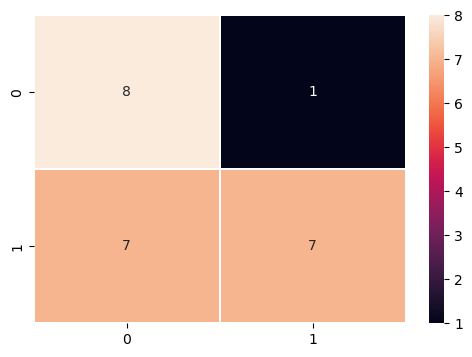

In [57]:
y_pred = grid.predict(x_test)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linewidths=0.1)
print('\n')
print(classification_report(y_test, y_pred))

It did worse than the base model. The best logistic regression model would be just to remove the 'age' variable and fit it then. That version will be used for the model comparisons.

In [58]:
# recreating the training set for the best logistic model.
df1 = df.drop(['Age'], axis=1)
x = np.array(df1.drop('Caesarian', axis=1))
y = np.array(df1.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

y_pred_log = np.round(logit_model1.predict(x_test))

## SVM Tuning

In [59]:
x = np.array(df.drop('Caesarian', axis=1))
y = np.array(df.Caesarian)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

In [60]:
svm_params = {
    'C': np.linspace(0.3, 0.5, 51),
    'gamma': np.linspace(0.2, 0.3, 51),
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'class_weight': [None, 'balanced'],
    'probability': [True, False],
    'degree': [1, 2, 3, 4]
}
grid = GridSearchCV(estimator=SVC(random_state=32),
                   param_grid=svm_params,
                   cv=4).fit(x_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Params: {grid.best_params_}')

Best Score: 0.6620879120879121
Params: {'C': 0.424, 'class_weight': 'balanced', 'degree': 1, 'gamma': 0.296, 'kernel': 'rbf', 'probability': True}


              precision    recall  f1-score   support

         0.0       0.53      0.89      0.67         9
         1.0       0.88      0.50      0.64        14

    accuracy                           0.65        23
   macro avg       0.70      0.69      0.65        23
weighted avg       0.74      0.65      0.65        23



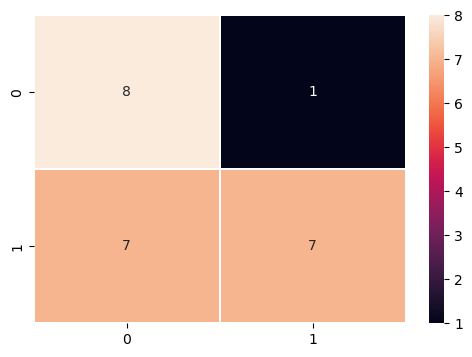

In [61]:
y_pred_svm = grid.predict(x_test)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot = True, linewidths=0.1)

print(classification_report(y_test, y_pred_svm))

The model has the same accuracy as its original form at 65%. What differed was that this model did better predicting the true negatives - when not to recommend c-sections when they aren't needed, and did worse at predicting when to proceed with the procedures. This model predicted 7 false negatives versus the 5 previously. The new model seems to skew its results towards predicting not to proceed with the c-section.

Because we are concerned with both accuracy and the FNR, the initial SVM model will be used in our model comparison.

## KNN Tuning

In [62]:
knn_params = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 20, 30, 40, 50, 55]
}
grid = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=9),
                   param_grid=knn_params,
                   cv=4).fit(x_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Params: {grid.best_params_}')

C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best Score: 0.6043956043956044
Params: {'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2, 'weights': 'uniform'}


C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73         9
         1.0       0.90      0.64      0.75        14

    accuracy                           0.74        23
   macro avg       0.76      0.77      0.74        23
weighted avg       0.79      0.74      0.74        23



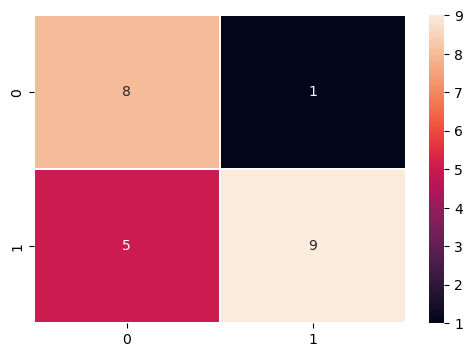

In [63]:
y_pred_knn = grid.predict(x_test)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot = True, linewidths=0.1)

print(classification_report(y_test, y_pred_knn))

The results are the same as the original KNN model even after trying various hyperparameters and cross validation sets.

## AdaBoost Tuning

In [65]:
ada_params = {
    'n_estimators':  [25, 50, 75, 80, 100, 125, 150, 180, 200, 210, 230, 250, 260, 270],
    'learning_rate': [0.00002, 0.000022, 0.0001, 0.0002, 0.00025, 0.0003, 0.00035, 0.0008, 0.001, 0.0012, 0.0013],
    'base_estimator': [DecisionTreeClassifier(max_depth=1),
                       DecisionTreeClassifier(max_depth=2),
                       DecisionTreeClassifier(max_depth=3)]
}
grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=32),
                   param_grid=ada_params,
                   cv=4).fit(x_train, y_train)

print(f'Best Score: {grid.best_score_}')
print(f'Params: {grid.best_params_}')


Best Score: 0.6414835164835164
Params: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.0001, 'n_estimators': 250}


              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63         9
         1.0       0.77      0.71      0.74        14

    accuracy                           0.70        23
   macro avg       0.68      0.69      0.69        23
weighted avg       0.70      0.70      0.70        23



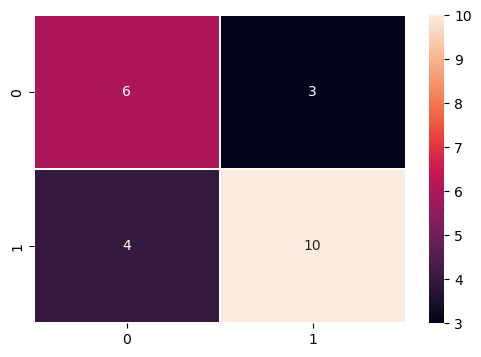

In [66]:
y_pred_ada = grid.predict(x_test)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot = True, linewidths=0.1)

print(classification_report(y_test, y_pred_ada))

The tuning of the adaboost model yielded a better result than its original. This model has higher accuracy by being able to predict true negatives better in comparison.

# Results

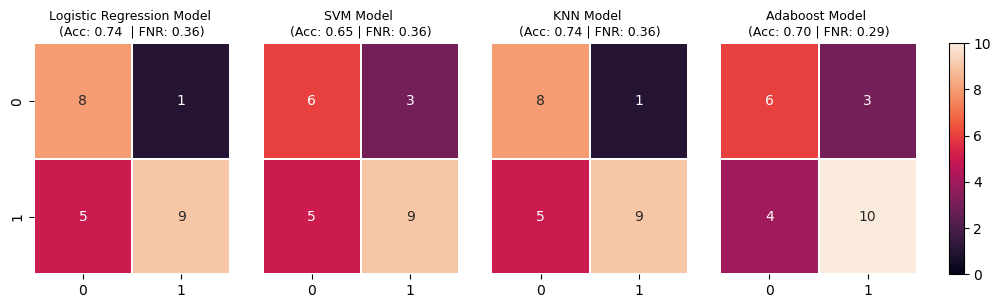

In [67]:
# creating subplots to show all heatmaps
fig, ax = plt.subplots(ncols = 5, figsize=(12, 3), gridspec_kw=dict(width_ratios=[4,4,4,4,0.3]))

# heatmaps for each model results
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot = True, linewidths=0.1, ax=ax[0], cbar=False, vmin=0, vmax=10)
sns.heatmap(confusion_matrix(y_test, yp_svm), annot = True, linewidths=0.1, yticklabels=False, ax=ax[1], cbar=False, vmin=0, vmax=10)
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot = True, linewidths=0.1, yticklabels=False, ax=ax[2], cbar=False, vmin=0, vmax=10)
sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot = True, linewidths=0.1, yticklabels=False, ax=ax[3], cbar=False, vmin=0, vmax=10)

# added the color bar
fig.colorbar(ax[1].collections[0], cax=ax[4])

# added title above each plot to show which model
ax[0].set_title('Logistic Regression Model \n(Acc: 0.74  | FNR: 0.36)', fontsize=9)
ax[1].set_title('SVM Model \n(Acc: 0.65 | FNR: 0.36)', fontsize=9)
ax[2].set_title('KNN Model \n(Acc: 0.74 | FNR: 0.36)', fontsize=9)
ax[3].set_title('Adaboost Model \n(Acc: 0.70 | FNR: 0.29)', fontsize=9)

plt.show()

Displayed above is a summary of the current best of each model. The logistic regression and KNN models had the highest accuracy at 0.74 and showed the same prediction results. The weakest model was the SVM model. It was able to predict true positives and false negatives at the same rate as the logistic and KNN models, but did worse identifying true negatives. Adaboost's results fall in between the three models. It was able to distinguish true positives and false positives much better than the other three but it it had the same ability to identify true negatives as the SVM model.

In the context of the problem, a false positive is predicting a c-section when a c-section was not performed. A false negative is predicting not to proceed with the surgery when a c-section was done. Because of the nature of the surgery, the weight of false negative is higher than a false positive. In the case of a false positive, the baby can still live despite the risks to both mothers and baby. However, if a false negative occurred, the baby might die as a result of the error.

In this case, the best model would be the adaboost it has relatively high accuracy and minimized the FNR the most. I think the small accuracy trade-off for minimizing false negatives is good in this context.

# Conclusion

At the end of the project we find that the Adaboost model performed the best overall. It was able to predict correctly 70% of the time and minimized false negatives as much as possible (FNR=0.29). This may seem a little high but that is because the testing data was quite small. The split of the whole data set was a 7/3 split and there were only 76 points left over by the time model development happened. The test set only had 23 samples. In the future, it would be better if a dataset with more samples were used. Furthermore, the lack of concise numbers for some of the features such as blood pressure may have made it difficult for the model to draw a more contextual line for classification. It was mentioned earlier but the importance on the state of the baby is very significant in determining when to proceed with the procedure or not. Therefore, for future studies, maybe include the size and or position of the child into the dataset for a more reliable model. 

Overall, after doing this study, I find that relying on machine learning algorithms to determine health related issues may be a little risky. It's decision rests on the training data that was used and whether it's going to be representative of the population. In the health care field, machine learning can be very useful but it shouldn't be used as the primary source. Not unless, you risk delivering your child safely. 